# Day 26 – Convolutional Neural Networks (CNNs)
### Image Recognition in Logistics

Today we’ll explore how **CNNs (Convolutional Neural Networks)** understand visual patterns — the foundation of image recognition systems.

#### Goals:
- Understand convolution & pooling layers
- Train a CNN on the CIFAR-10 dataset
- Evaluate accuracy and visualize results
- Learn how deep models process visual data

In [2]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm.auto import tqdm # For a nice progress bar
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# Add detailed verification
if device == 'cuda':
    print(f'CUDA Version: {torch.version.cuda}')
    print(f'GPU Name: {torch.cuda.get_device_name(0)}')
else:
    print('PyTorch is not using the GPU. Please check your installation and drivers.')

Using device: cuda
CUDA Version: 12.1
GPU Name: NVIDIA GeForce RTX 4050 Laptop GPU


c:\Users\vedav\OneDrive\Documents\LLM-Engineer\LLM-Engineer-Prerequisites\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load and Normalize CIFAR-10 Dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)
classes = trainset.classes
print(classes)

100%|██████████| 170M/170M [00:21<00:00, 7.78MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 2. Visualize Sample Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.81960785].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.60784316].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.827451].
Clipping input data

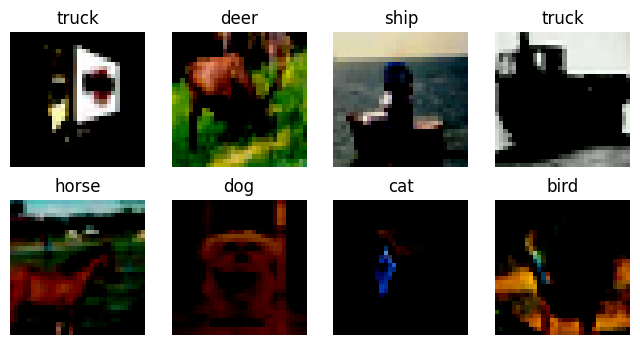

In [3]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
plt.figure(figsize=(8,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(np.transpose(images[i].numpy(), (1,2,0)))
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.show()

## 3. Define CNN Model

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)


## 4. Define Optimizer and Check for Checkpoint

In [5]:
MODEL_PATH = 'cifar_cnn.pth'

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Try to load a saved model to resume training
try:
    model.load_state_dict(torch.load(MODEL_PATH))
    print(f'Successfully loaded model from {MODEL_PATH}. Resuming training.')
except FileNotFoundError:
    print('No saved model found. Starting training from scratch.')

Successfully loaded model from cifar_cnn.pth. Resuming training.


C:\Users\vedav\AppData\Local\Temp\ipykernel_56244\2778947200.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


## 4. Train Model

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss_history = []
num_epochs = 5 # Let's keep it at 5 for now, it will be much faster on GPU

try:
    for epoch in range(num_epochs):
        running_loss = 0.0
        # Wrap trainloader with tqdm for a progress bar
        progress_bar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
        for i, (inputs, labels) in enumerate(progress_bar):
            inputs, labels = inputs.to(device), labels.to(device) # Move data to GPU
            optimizer.zero_grad() # Reset gradients
            outputs = model(inputs) # Forward pass
            loss = criterion(outputs, labels) # Calculate loss
            loss.backward() # Backward pass
            optimizer.step() # Update weights
            running_loss += loss.item() # Accumulate loss
            # Update the progress bar postfix
            progress_bar.set_postfix({'loss': running_loss / (i + 1)})
        epoch_loss = running_loss / len(trainloader) # Average loss for the epoch
        train_loss_history.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
        
        # Save the model after each epoch
        torch.save(model.state_dict(), MODEL_PATH)
except KeyboardInterrupt:
    print('\nTraining interrupted. Finishing up...')
finally:
    print(f'\nTraining finished. Model saved to {MODEL_PATH}')

Epoch 1/5, Loss: 1.5516


Epoch 2/5, Loss: 1.2675


Epoch 3/5, Loss: 1.1322


Epoch 4/5, Loss: 1.0287


Epoch 5/5, Loss: 0.9569

Training finished. Model saved to cifar_cnn.pth


## 5. Evaluate Model

In [6]:
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 64.90%
